# SRGAN demonstration for QR code enhancement

# QR code enhancer
An attempt to ustilise Super Resolution Generative Adversarial Networks (SRGANs) on QR codes to enhance images.  

Most qr scanners require the scanning image to be greater than 2cms x 2cms. However, I believe we can shrink the size by a respectable factor. This can be made possibile by artificial resolution-enhancement. This application opens a lot of possibilities for significantly quicker realtime detection 
## References
Link to dataset- https://www.kaggle.com/datasets/coledie/qr-codes

Link to the original paper- https://arxiv.org/abs/1609.04802

Excellent repo I based my work on - https://github.com/bnsreenu/python_for_microscopists/tree/master/255_256_SRGAN
# Files in repository
main.py ---> contains the main model architecture

Superresolution.ipynp ---> A detailed notebook for downloading the model, augmenting image data, preparing and compiling the final model, and finally running it
# Understanding SRGAN architecture 
SRGAN is a generative adversarial network for single image super-resolution. It uses a perceptual loss function which consists of an adversarial loss and a content loss. The adversarial loss pushes the solution to the natural image manifold using a discriminator network that is trained to differentiate between the super-resolved images and original photo-realistic images. 

## The Generator

![image](https://user-images.githubusercontent.com/99831413/166132910-9a7e508b-bead-4599-904f-ece3f38a0845.png)

 The generator architecture of the SRRESNET generator network consists of the low-resolution input, which is passed through an initial convolutional layer of 9×9 kernels and 64 feature maps followed by a Parametric ReLU layer. The reason for choosing the Parametric ReLU is because it is one of the best non-linear functions for this particular task of mapping low-resolution images to high-resolution images.
 
 ## The Discriminator
 
 ![image](https://user-images.githubusercontent.com/99831413/166132890-ee9647be-ec3f-462d-a4ef-517be8d778dd.png)

 
 The discriminator architecture is constructed in the best way to support a typical GAN procedure. Both the generator and discriminator are competing with each other, and they are both improving simultaneously. While the discriminator network tries to find the fake images, the generator tries to produce realistic images so that it can escape the detection from the discriminator. The working in the case of SRGANs is similar as well, where the generative model G with the goal of fooling a differentiable discriminator D that is trained to distinguish super-resolved images from real images.

Hence the discriminator architecture shown in the above image works to differentiate between the super-resolution images and the real images.


# Performance so far

## Epoch one

![download](https://user-images.githubusercontent.com/99831413/166133210-64a050a4-79f4-4d19-b931-96d0e80ad335.png)

## Epoch two

![image](https://user-images.githubusercontent.com/99831413/166930498-8cbf29d5-d2d0-454a-b084-1add23e8d545.png)

## Epoch three

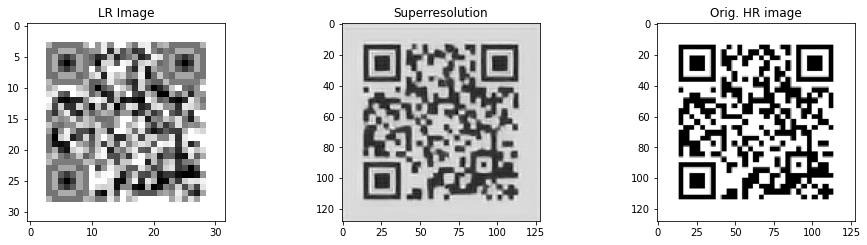

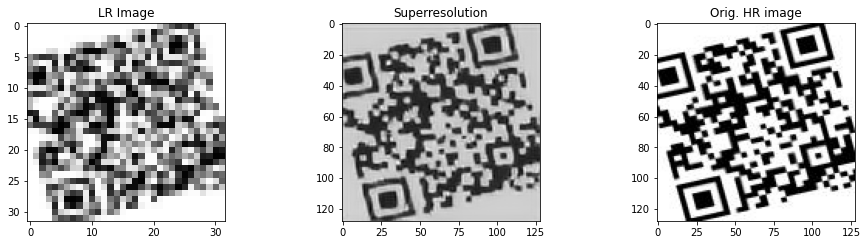

# Try the notebook for yourself, ggs

## Installing dependencies+ Unzipping data

In [1]:
#downloading the main model architecture
!wget https://raw.githubusercontent.com/PsVenom/QR-code-enhancement-using-SRGANs/main/main.py

--2024-06-20 21:48:38--  https://raw.githubusercontent.com/PsVenom/QR-code-enhancement-using-SRGANs/main/main.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3020 (2.9K) [text/plain]
Saving to: ‘main.py’

main.py             100%[===================>]   2.95K  --.-KB/s    in 0s      

2024-06-20 21:48:38 (37.8 MB/s) - ‘main.py’ saved [3020/3020]



In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
!pip install opencv-python
!pip install tqdm
!pip install scikit-image

## looking at a single example

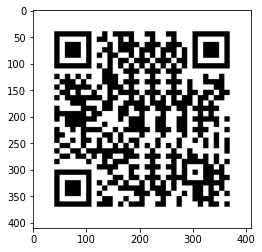

In [4]:
import cv2 
import os
datadir = '../input/qr-codes/qr_dataset'
# iterating over just one element
for img in os.listdir(datadir): 
        img_array = cv2.imread(os.path.join(datadir,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break

## storing the images

In [5]:
#generalising this technique for all other images 
array = []
array_small =[]
from tqdm import tqdm
def create_training_data():
        for img in tqdm(list(os.listdir(datadir))):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(datadir+'/'+img ,cv2.IMREAD_COLOR)  # convert to array
                new_array = cv2.resize(img_array, (128, 128))  # resize to normalize data size
                array.append([new_array]) 
                array_small.append([cv2.resize(img_array, (32,32),
                               interpolation=cv2.INTER_AREA)]) # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
create_training_data()

100%|██████████| 10000/10000 [00:52<00:00, 192.02it/s]


In [6]:
len(array)

10000

In [7]:
X = []
Xs = []
for features in array:
    X.append(features)
for features in array_small:
    Xs.append(features)
X = np.array(X).reshape(-1, 128, 128, 3)
Xs = np.array(Xs).reshape(-1, 32, 32, 3)


Image Augmentation (offline)

In [8]:
#augmenting the data
#we'll externally store the augmented images using keras's ImageDataGenerator. However, we'll have to create a directory first
os.mkdir('/kaggle/working/Augmented-images/')
from keras.preprocessing.image import ImageDataGenerator #this generator will save files in a physical format
from skimage import io
datagen = ImageDataGenerator(        
        rotation_range = 40,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))
#now that we've initialised the augmentor,all that's left is to use it 

for a in X:
 i = 0
 a = a.reshape((1, ) + a.shape)
 for batch in datagen.flow(a, batch_size=1,  save_to_dir= 'Augmented-images', save_prefix='dr', save_format='jpeg'):    
  try:
    i += 1   
    if i>= 10:
      break 
  except Exception:
    print("error")
    pass

#this will take a while (about 18 minutes) so you can brew some good ol' coffee while you're at it


## loading augmented images and adding them to image array

In [9]:
array=[]
array_small=[]
datadir = 'Augmented-images'
create_training_data()

100%|██████████| 10000/10000 [00:02<00:00, 3364.33it/s]


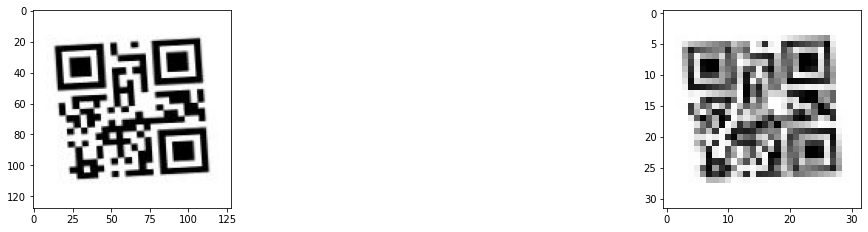

In [10]:
X1 =  []
Xs1 = []
for features in array:
    X1.append(features)
for features in array_small:
    Xs1.append(features)
plt.figure(figsize=(16, 8))
X1 = np.array(X1).reshape(-1, 128, 128, 3)
Xs1 = np.array(Xs1).reshape(-1, 32, 32, 3)
plt.subplot(231)
plt.imshow(X1[0], cmap = 'gray')
plt.subplot(233)
plt.imshow(Xs1[0], cmap = 'gray')
plt.show()

In [11]:
X=np.concatenate((X,X1), axis = 0)
Xs=np.concatenate((Xs,Xs1), axis=0)
X.shape

(20000, 128, 128, 3)

# Training and validation


creating training split

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train, y_valid = train_test_split(Xs, X, test_size = 0.33, random_state = 12)
X_train.shape

(13400, 32, 32, 3)

In [13]:
from main import *

## creating the final generative network

In [14]:
# the generator and discriminator models are taken from main.py
hr_shape = (y_train.shape[1], y_train.shape[2], y_train.shape[3])
lr_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = generator(lr_ip, res_range = 16, upscale_range=2)
generator.summary()

discriminator = discriminator(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 32, 32, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   36928       p_re_lu[0][0]                    
______________________________________________________________________________________________

In [15]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128, 128, 3)  2044291     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            38249281    model[0][0]                      
____________________________________________________________________________________________

In [16]:
#preparing the data batches
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(y_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(y_train[start_idx:end_idx])
    train_lr_batches.append(X_train[start_idx:end_idx])
    

# creating training loop for 5 epochs
## The training process will take a while (approx 1.5 hour per epoch)

In [17]:
epochs = 3
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


100%|██████████| 13400/13400 [29:59<00:00,  7.45it/s]


epoch: 1 g_loss: 344904.7469245569 d_loss: [0.40378397 0.98996269]


100%|██████████| 13400/13400 [29:31<00:00,  7.56it/s]


epoch: 2 g_loss: 188911.67913596082 d_loss: [0.35514045 0.9988806 ]


100%|██████████| 13400/13400 [29:46<00:00,  7.50it/s]

epoch: 3 g_loss: 119262.9470292823 d_loss: [0.45661309 0.99899254]


## checking the generator output

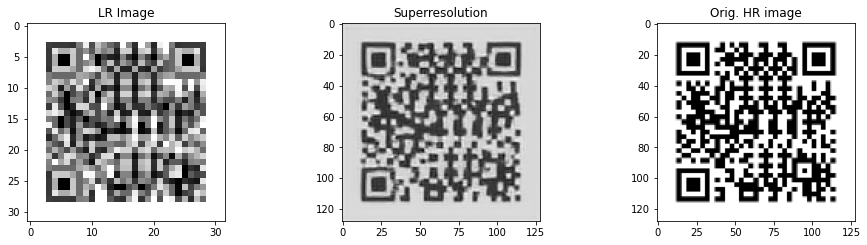

In [19]:
from keras.models import load_model
from numpy.random import randint

[X1, X2] = [X_valid, y_valid]
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:], cmap = 'gray')
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(cv2.cvtColor(gen_image[0,:,:,:], cv2.COLOR_BGR2GRAY),cmap = 'gray')
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:], cmap = 'gray')

plt.show()
